# Import Library

In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
import pandas_profiling
import joblib
import matplotlib.pyplot as plt
import xgboost as xgb
import json
import pickle
import category_encoders as ce
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from utils.utils import *
from utils.surface_area import *
%matplotlib inline

# Explore Data

In [2]:
df = pd.read_csv('data/test/test.csv')
print(df.dtypes)

MOFname                                           object
volume [A^3]                                     float64
weight [u]                                       float64
surface_area [m^2/g]                             float64
void_fraction                                    float64
void_volume [cm^3/g]                             float64
functional_groups                                 object
metal_linker                                       int64
organic_linker1                                    int64
organic_linker2                                    int64
topology                                          object
CO2/N2_selectivity                               float64
heat_adsorption_CO2_P0.15bar_T298K [kcal/mol]    float64
dtype: object


In [3]:
print(df.isnull().sum())

MOFname                                             0
volume [A^3]                                        0
weight [u]                                          0
surface_area [m^2/g]                                0
void_fraction                                       0
void_volume [cm^3/g]                                0
functional_groups                                 323
metal_linker                                        0
organic_linker1                                     0
organic_linker2                                     0
topology                                            0
CO2/N2_selectivity                                  0
heat_adsorption_CO2_P0.15bar_T298K [kcal/mol]    2087
CO2_working_capacity [mL/g]                         0
dtype: int64


In [4]:
df = df.dropna(subset=['functional_groups'])
df = df.reset_index(drop=True)
print(df.isnull().sum())

MOFname                                             0
volume [A^3]                                        0
weight [u]                                          0
surface_area [m^2/g]                                0
void_fraction                                       0
void_volume [cm^3/g]                                0
functional_groups                                   0
metal_linker                                        0
organic_linker1                                     0
organic_linker2                                     0
topology                                            0
CO2/N2_selectivity                                  0
heat_adsorption_CO2_P0.15bar_T298K [kcal/mol]    2085
CO2_working_capacity [mL/g]                         0
dtype: int64


## Overall Data

In [5]:
profile = pandas_profiling.ProfileReport(df, minimal=True)

In [6]:
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/22 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Explore Nan and Inf in Heat Absorp

In [18]:
heat_absorp = np.array(df['heat_adsorption_CO2_P0.15bar_T298K [kcal/mol]'])
print("Count Nan: {}".format(np.isnan(heat_absorp).sum()))
print("Count Inf: {}".format(np.isinf(heat_absorp).sum()))

Count Nan: 2085
Count Inf: 2


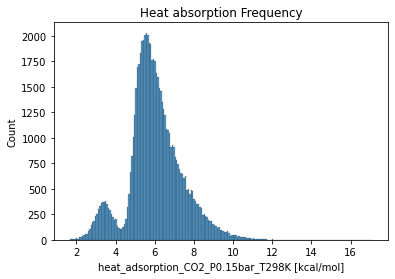

In [19]:
sns.histplot(data=df, x='heat_adsorption_CO2_P0.15bar_T298K [kcal/mol]')
plt.title('Heat absorption Frequency')
plt.show()

In [20]:
df = generate_selectivity_catalog(df)

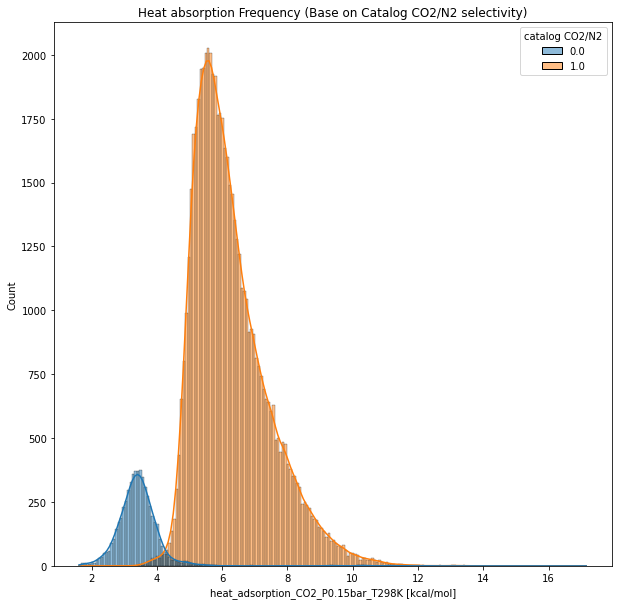

In [21]:
plt.figure(figsize=(10, 10))
sns.histplot(data=df, x='heat_adsorption_CO2_P0.15bar_T298K [kcal/mol]', hue='catalog CO2/N2', kde=True)
plt.title('Heat absorption Frequency (Base on Catalog CO2/N2 selectivity)')
plt.show()

## Explore Nan in Function groups

In [22]:
function_groups_encoder = {}

for i, ele in enumerate(df['functional_groups'].unique()):
    function_groups_encoder[ele] = i

json.dump(function_groups_encoder, open('model/general/functional_groups_encoder.json', 'w'))

## Explore Topology

In [23]:
topo_encoder = {}

for i, ele in enumerate(df['topology'].unique()):
    topo_encoder[ele] = i

print(topo_encoder)
json.dump(topo_encoder, open('model/general/topology_encoder.json', 'w'))

{'pcu': 0, 'etb': 1, 'sra': 2, 'acs': 3, 'fof': 4, 'bcu': 5, 'nbo': 6, 'tbo': 7, 'pts': 8, 'the': 9, 'rht': 10}


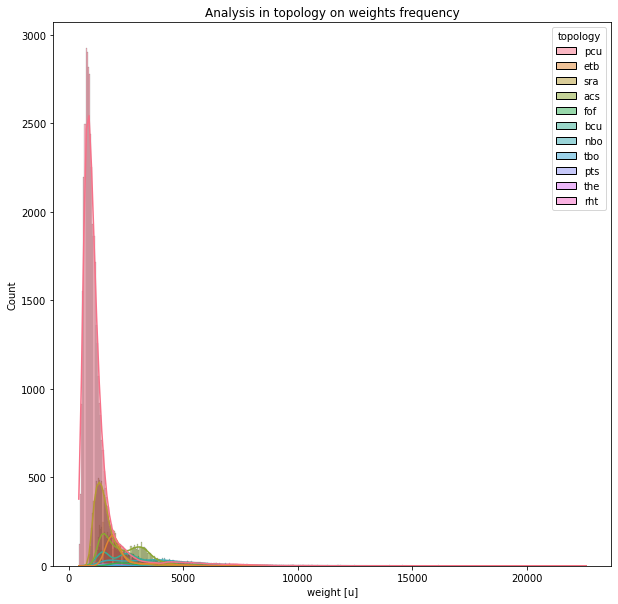

In [24]:
plt.figure(figsize=(10, 10))
sns.histplot(data=df, x='weight [u]', hue='topology', kde=True)
plt.title('Analysis in topology on weights frequency')
plt.show()

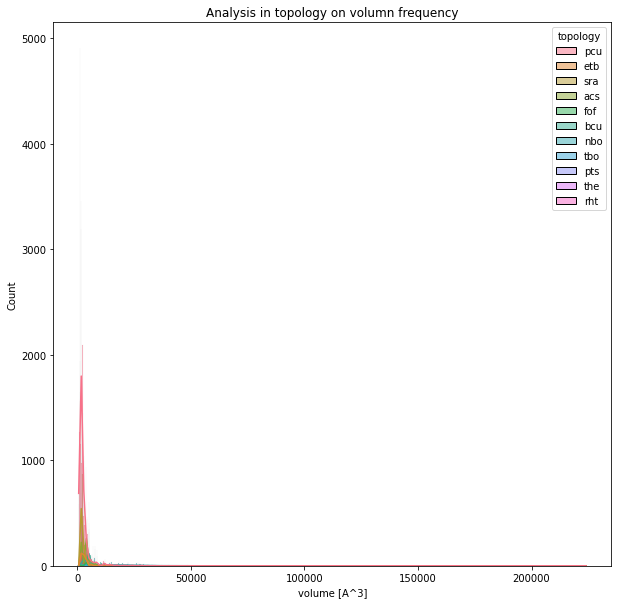

In [25]:
plt.figure(figsize=(10, 10))
sns.histplot(data=df, x='volume [A^3]', hue='topology', kde=True)
plt.title('Analysis in topology on volumn frequency')
plt.show()

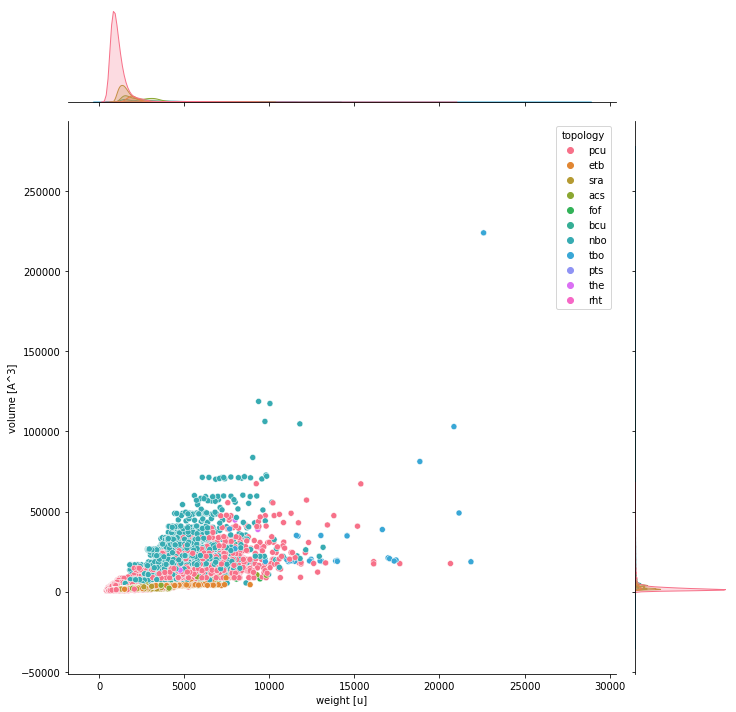

In [26]:
sns.jointplot(data=df, x='weight [u]', y='volume [A^3]', hue='topology', height=10)
plt.show()

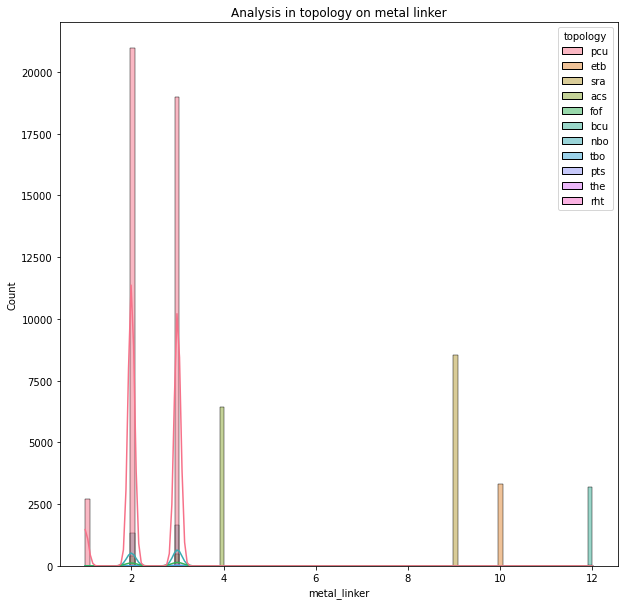

In [27]:
plt.figure(figsize=(10, 10))
sns.histplot(data=df, x='metal_linker', hue='topology', kde=True)
plt.title('Analysis in topology on metal linker')
plt.show()

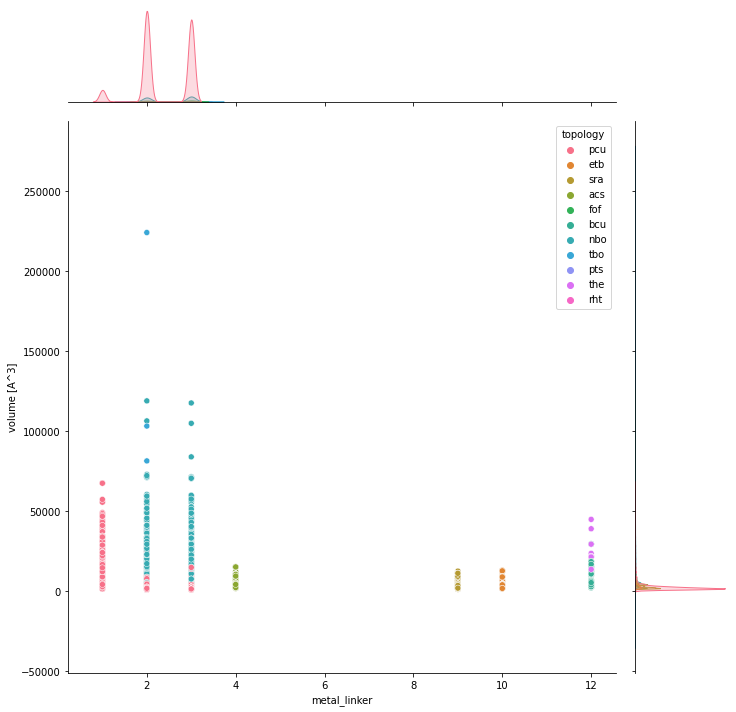

In [28]:
sns.jointplot(data=df, x='metal_linker', y='volume [A^3]', hue='topology', height=10)
plt.show()

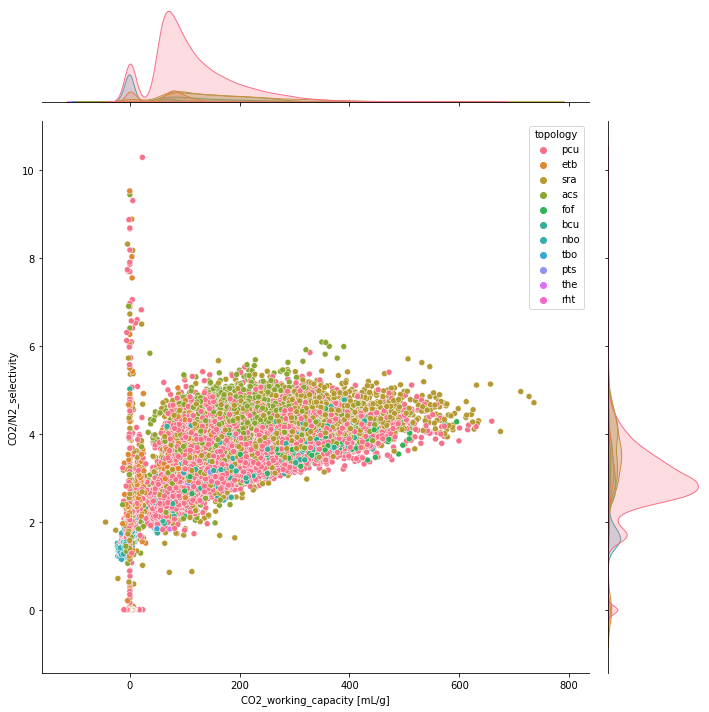

In [29]:
x = df['CO2_working_capacity [mL/g]']
y = df['CO2/N2_selectivity']

sns.jointplot(data=df, x=x, y=np.log(1+y), hue='topology', height=10)
plt.show()

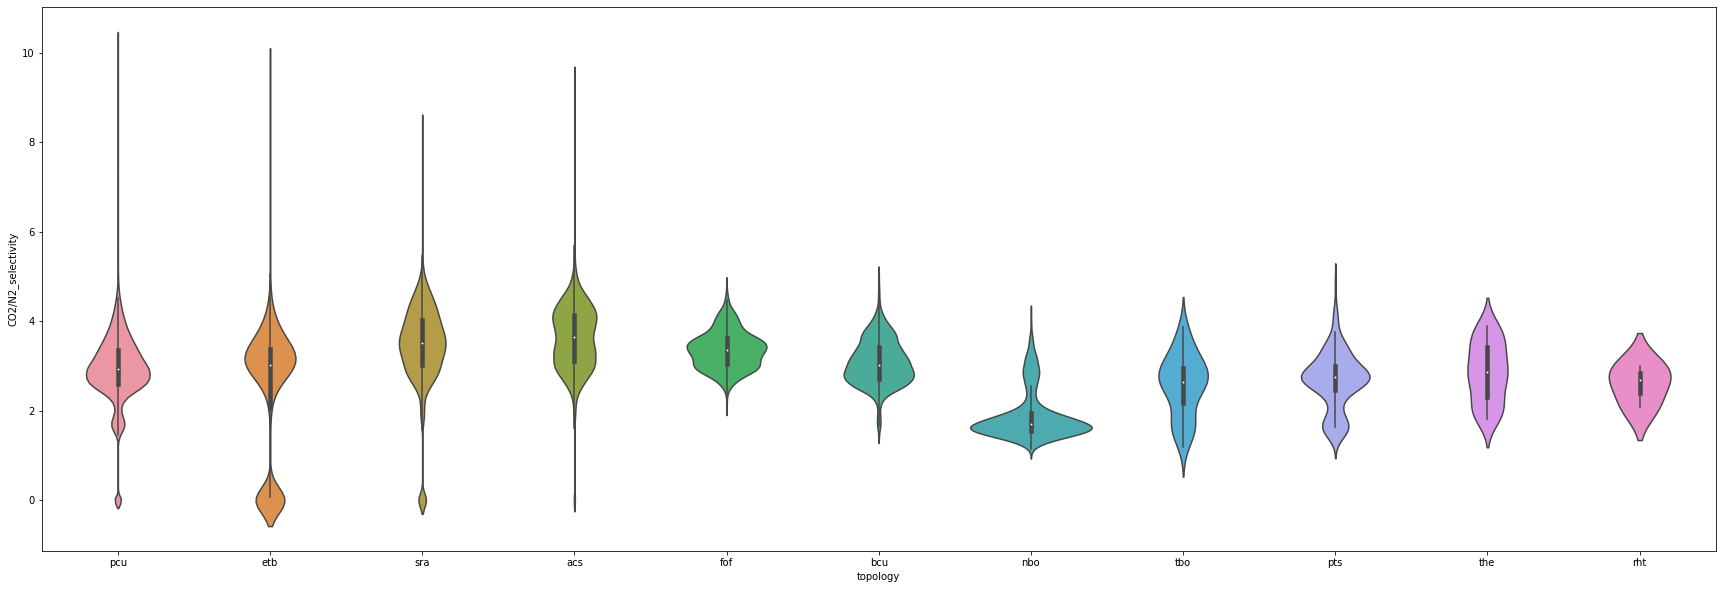

In [30]:
plt.figure(figsize=(30, 10))
sns.violinplot(data=df, x='topology', y=np.log(1+y))
plt.show()

# Visualize Structural

In [5]:
# Numurical array
import numpy as np
# for manipulating a structure
from ase.io import read, write
from ase import Atoms 
# for finding and handling crystal symmetries
from spglib import *

# for visualization
import py3Dmol

# Own
import os
import pandas
from utils.surface_area import *
import openbabel.pybel as pybel

In [6]:
def analyze_symmetry(cif,symprec=1e-5):
    # input cell 
    print('Dataset: Input structure')
    ase_atoms = read(cif) 
    cf = ase_atoms.get_chemical_formula()
    print('Chemical formula: %s' %(cf))
    sym = ase_atoms.get_chemical_symbols()
    Natoms = len(sym)
    cellparams = ase_atoms.get_cell_lengths_and_angles() 
    print('Cell parameters = ',cellparams)
    print('Cell vectors    = ',ase_atoms.cell[0],ase_atoms.cell[1],ase_atoms.cell[2])
    print('Natoms = %i' % Natoms)

In [7]:
mof_cif = "data/train/mof_cif_train/mof_unit_1.cif"

cif = open(mof_cif, "r").read()
viewer = py3Dmol.view()
viewer.addModel(cif,'cif',{'doAssembly':True,'duplicateAssemblyAtoms':True})
viewer.setStyle({'sphere':{'colorscheme':'Jmol','scale':.3},'stick':{'colorscheme':'Jmol'}})
# viewer.setStyle({'sym':2},{'sphere':{'scale':.5,'color':'blue'},'stick':{'color':'cyan'}})
viewer.addUnitCell()
viewer.zoomTo()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [8]:
mof_cif = "data/train/mof_cif_train/mof_unit_10000.cif"
analyze_symmetry(mof_cif)

Dataset: Input structure
Chemical formula: C70H67Ba2N5O28P8
Cell parameters =  [ 8.210619 15.163118 26.991096 99.052447 92.386237 81.123988]
Cell vectors    =  [8.210619 0.       0.      ] [ 2.33961974 14.98153286  0.        ] [-1.12379192 -4.12271252 26.65069598]
Natoms = 180


C:\Users\User\anaconda3\envs\TMLCC_CUDA\lib\site-packages\ase\io\cif.py:404: UserWarning: crystal system 'triclinic' is not interpreted for space group 1. This may result in wrong setting!
  setting_name, spacegroup))
C:\Users\User\anaconda3\envs\TMLCC_CUDA\lib\site-packages\ase\utils\__init__.py:62: FutureWarning: Please use atoms.cell.cellpar() instead
  warnings.warn(warning)


## Smiles

In [9]:
cif_path = "data/test/mof_cif_test"
xyz_path = "data/test/mof_xyz_test"

df = pd.read_csv("data/test/test.csv")
filenames = df['MOFname']
smiles = []

In [10]:
def xyz_to_smiles(fname: str) -> str:
    mol = next(pybel.readfile("xyz", fname))
    smi = mol.write(format="smi")
    return smi.split()[0].strip()

In [11]:
for filename in filenames:
#     if filename in ['mof_unit_56792', 'mof_unit_63696']:
#         smiles.append(np.NaN)
#     else:
    mof = read(os.path.join(cif_path, "{}.cif".format(filename)))
    mof_xyz = os.path.join(xyz_path, "{}.xyz".format(filename))
    mof.write(mof_xyz)

    smi = xyz_to_smiles(mof_xyz)
    smiles.append(smi)

C:\Users\User\anaconda3\envs\TMLCC_CUDA\lib\site-packages\ase\io\cif.py:404: UserWarning: crystal system 'monoclinic' is not interpreted for space group 1. This may result in wrong setting!
  setting_name, spacegroup))
C:\Users\User\anaconda3\envs\TMLCC_CUDA\lib\site-packages\ase\spacegroup\spacegroup.py:435: UserWarning: scaled_positions 180 and 181 are equivalent
  (kinds[ind], kind))
C:\Users\User\anaconda3\envs\TMLCC_CUDA\lib\site-packages\ase\spacegroup\spacegroup.py:435: UserWarning: scaled_positions 216 and 217 are equivalent
  (kinds[ind], kind))
C:\Users\User\anaconda3\envs\TMLCC_CUDA\lib\site-packages\ase\io\cif.py:404: UserWarning: crystal system 'orthorhombic' is not interpreted for space group 1. This may result in wrong setting!
  setting_name, spacegroup))
C:\Users\User\anaconda3\envs\TMLCC_CUDA\lib\site-packages\ase\spacegroup\spacegroup.py:435: UserWarning: scaled_positions 103 and 104 are equivalent
  (kinds[ind], kind))
C:\Users\User\anaconda3\envs\TMLCC_CUDA\lib\sit

In [12]:
np_filenames = np.expand_dims(np.array(filenames), axis=1)
np_smiles = np.expand_dims(np.array(smiles), axis=1)
data = np.concatenate((np_filenames, np_smiles), axis=1)
print(data.shape)

(17000, 2)


In [13]:
df_smiles = pd.DataFrame(data, columns=["MOFname", "Smiles"])
print(df_smiles)

              MOFname                                             Smiles
0      mof_unit_68614  [C]1([C])O[Cu]234([Cu]([N])(O[C]([C])O2)(O1)(O...
1      mof_unit_68615  C(=O)(C1=C(c2c([C]=[C]1)c1[C]=CC(=Cc1cc2I)[C]1...
2      mof_unit_68616  C\1(=C\[C]C#N)/O[Zn]23(N[CH])O[C](C4=C(C#N)C(=...
3      mof_unit_68617  C1(=C([CH])[CH])O[Cu]234([Cu](N([C]OC)[C]OC)(O...
4      mof_unit_68618  O1[C](O[Zn]23(O[C](O[Zn]1(O[C](O3)C#[C])(O[C](...
...               ...                                                ...
16995  mof_unit_85609  O([C](O[Zn][O])c1ccc(c2c(cc(c3ccc(cc3N(=O)=O)[...
16996  mof_unit_85610  [C](=O)[C]/C=C\[C][C]O[Zn].c1(cc(C(=O)[O])ccc1...
16997  mof_unit_85611  [C]1(c2c(c(c([C])c(c2C)C#N)C#N)C)O[Cu]234([Cu]...
16998  mof_unit_85612  [C]1(c2c(cc(c(c2)C=O)[C])C=O)O[Zn]23(N4[C](C=C...
16999  mof_unit_85613  c12-c3ccc(cc3)[C](O[Zn][O])O[Zn@@]3([O])O[Zn](...

[17000 rows x 2 columns]


In [14]:
df_smiles.to_csv('data/test/smiles_test.csv', index=False)

In [22]:
s1 = pd.read_csv('data/train/smiles_train1.csv')
s2 = pd.read_csv('data/train/smiles_train2.csv')
s3 = pd.read_csv('data/train/smiles_train3.csv')
s4 = pd.read_csv('data/train/smiles_train4.csv')
s5 = pd.read_csv('data/train/smiles_train5.csv')

smiles_dataframe = pd.concat([s1, s2, s3, s4, s5]).reset_index(drop=True)
smiles_dataframe.to_csv('data/train/smiles_train.csv', index=False)
print(smiles_dataframe)

              MOFname                                             Smiles
0          mof_unit_1  O1/C(=C(\[C][CH]C(=O)O)/[C]C(=O)O)/O[Zn]23(O[C...
1          mof_unit_2  P([O])([O])C1=[C]C2=C(C=C([C]=[C]2)[CH])C(=C1)...
2          mof_unit_3  [C]1(C([CH2])([CH2])[CH2])O[Cu]234([Cu]([N]([C...
3          mof_unit_4  O1[C](O[V]2(O[C](O[V]1(O2)(O[C][C@@]12[C][C@H]...
4          mof_unit_5  [C]1(/C(=[C]\O)/[C]O)O[Cu]234([Cu](N([C]NC)[C]...
...               ...                                                ...
68608  mof_unit_68609  [C]1(/C(=[C]\C[C])/[C][CH]CCC)O[Zn]23(N([C]F)[...
68609  mof_unit_68610  [Ba](O[P@@](=O)([C](/C=C(\[C])/[P][O])[C])OCC)...
68610  mof_unit_68611  [C]1(c2c3c(c(cc2)C(=O)[O])cccc3)O[Cr@]23O[C](c...
68611  mof_unit_68612  C\1(=C/2\C=C[C]([C]3O[Cr](O[C](C(=[CH])[C][CH2...
68612  mof_unit_68613  C(=O)(/C(=[C]\I)/[C]([C])/C=C\[C])O[Cu@@](N1C(...

[68613 rows x 2 columns]


## Parameter in Unit Cell of MOF

In [7]:
cif_path = "data/test/mof_cif_test"

df = pd.read_csv("data/test/test.csv")
filenames = df['MOFname']
parameters = []

In [8]:
for filename in filenames:
    param = get_box_parameters('data/test/mof_cif_test/{}.cif'.format(filename))
    parameters.append(param)

In [9]:
np_filenames = np.expand_dims(np.array(filenames), axis=1)
np_parameters = np.array(parameters)
data = np.concatenate((np_filenames, np_parameters), axis=1)
df_param = pd.DataFrame(data, columns=["MOFname", "_cell_length_a", "_cell_length_b", "_cell_length_c", 
                                      "_cell_angle_alpha", "_cell_angle_beta", "_cell_angle_gamma"])
print(data.shape)
df_param = df_param.convert_dtypes()
df_param.to_csv("data/test/mof_params.csv", index=False)

(17000, 7)


In [55]:
df_join = df.join(df_paramdd.set_index('MOFname'), on='MOFname')

## Tensorboard

In [16]:
from torchsummary import summary
import numpy as np
import torch
from torch.utils.tensorboard import SummaryWriter
import pandas as pd

In [34]:
df = pd.read_csv('data/train/Latent_SAGE_feat_train.csv')
df_num = pd.read_csv('data/train/clean_train.csv').set_index('MOFname')
df_topo = pd.read_csv('data/train/train.csv').set_index('MOFname').topology
y = df.drop(['target', 'mofname'], axis=1).to_numpy()
label = df['target'].to_numpy()
error = np.abs(df['target'].to_numpy() - df['predict'].to_numpy())

df = df.join(df_num, on='mofname')
surface_area = df['surface_area [m^2/g]']
df = df.join(df_topo, on='mofname')
topo = df['topology']

topo_encoder = {}

for i, ele in enumerate(df['topology'].unique()):
    topo_encoder[ele] = i
    
topo = topo.replace(topo_encoder)
print(topo_encoder)

{'pcu': 0, 'etb': 1, 'sra': 2, 'acs': 3, 'fof': 4, 'bcu': 5, 'nbo': 6, 'tbo': 7, 'pts': 8, 'the': 9}


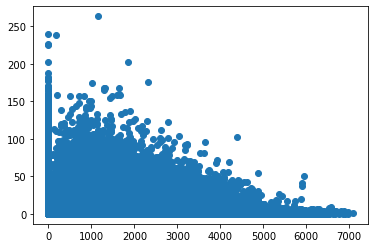

In [35]:
plt.scatter(surface_area, error)

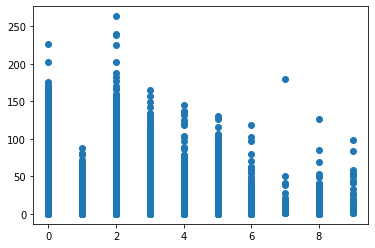

In [36]:
plt.scatter(topo, error)

In [41]:
df_num.isna().sum()

topo_0                                           0
topo_1                                           0
topo_2                                           0
topo_3                                           0
topo_4                                           0
topo_5                                           0
topo_6                                           0
topo_7                                           0
topo_8                                           0
topo_9                                           0
volume [A^3]                                     0
weight [u]                                       0
density [g/cm^3]                                 0
surface_area [m^2/g]                             0
void_fraction                                    0
void_volume [cm^3/g]                             0
functional_groups                                0
metal_linker                                     0
organic_linker1                                  0
organic_linker2                

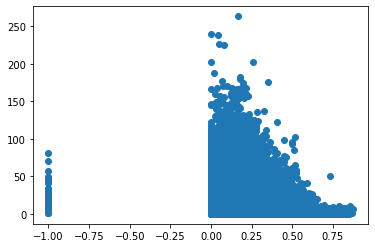

In [52]:
plt.scatter(df['void_fraction'], error)

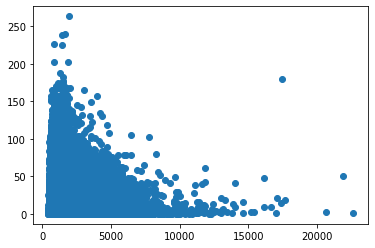

In [43]:
plt.scatter(df['weight [u]'], error)

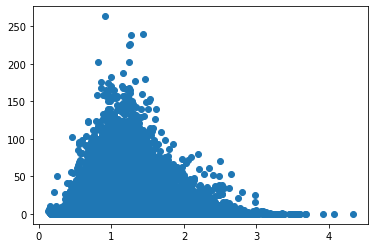

In [44]:
plt.scatter(df['density [g/cm^3]'], error)